Getting data from OPEN-OCRA

In [1]:
from datasets import load_dataset 
import numpy as np 
from datasets import Dataset
import matplotlib.pyplot as plt
 
dataset = load_dataset("Open-Orca/OpenOrca")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'system_prompt', 'question', 'response'],
        num_rows: 4233923
    })
})


Tokenization of instruction 

In [2]:


def token(text):
    return len(text.split())

def filter_function(example):
    return token(example['response']) >= 100

token_dataset = dataset.filter(filter_function)


print(token_dataset)

print(token_dataset['train'][0])


DatasetDict({
    train: Dataset({
        features: ['id', 'system_prompt', 'question', 'response'],
        num_rows: 1216347
    })
})
{'id': 'flan.2136716', 'system_prompt': 'You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the task think step-by-step and justify your steps.', 'question': 'Multi-choice question: What is the sentiment of the following tweet?\nTweet: @nikkigreen I told you \nChoose your answer from:\n + negative;\n + positive;', 'response': 'To determine the sentiment of the tweet, we need to analyze it thoroughly.\n\nTweet: @nikkigreen I told you\n\nStep 1: Identify the words or phrases that carry emotional weight.\nIn this tweet, there is only one phrase worth examining: "I told you."\n\nStep 2: Determine the sentiment of the identified words or phrases.\n"I told you" can carry a variety of sentiments, depending on the context. It could be positive, negative, or neutral.\n\nStep 3: 

Data Deduplication and Converting into CSV file 

In [3]:


def cosine_similarity(text1, text2):
    """Calculates cosine similarity between two text vectors."""
    tokens1 = text1.split()
    tokens2 = text2.split()

    unique_tokens = list(set(tokens1 + tokens2))
    vec1 = np.zeros(len(unique_tokens))
    vec2 = np.zeros(len(unique_tokens))

    token_index = {token: i for i, token in enumerate(unique_tokens)}

    for token in tokens1:
        vec1[token_index[token]] += 1

    for token in tokens2:
        vec2[token_index[token]] += 1

    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)
    
    if magnitude1 > 0 and magnitude2 > 0:
        cosine_sim = dot_product / (magnitude1 * magnitude2)
    else:
        cosine_sim = 0.0
    
    return cosine_sim

def deduplicate_dataset(dataset, threshold=0.95):
    
    seen_instructions = []
    filtered_dataset = []
    
    for examples in dataset:
        text = examples['instruction']
        is_duplicate = False
        
        for seen_text in seen_instructions:
            similarity = cosine_similarity(text, seen_text)
            if similarity >= threshold:
                is_duplicate = True
                break
        
        if not is_duplicate:
            seen_instructions.append(text)
            filtered_dataset.append(examples)
    
    return Dataset.from_list(filtered_dataset)

def save_data_to_csv(data, filepath):
    with open(filepath, "w", newline="") as f:
        f.write("instruction\n")
        for examples in data:
            instruction = examples["instruction"]
            f.write(f"{instruction}\n")

# Example dataset
train_data = Dataset.from_dict({
    "instruction": ["Example instruction 1", "Example instruction 2", "Example instruction 1"]
})

print(train_data)
# Deduplicate dataset
deduplicated_data = deduplicate_dataset(train_data)

# Specify a descriptive filename for the deduplicated data
open_ocra_deduplicated = "deduplicated_instructions.csv"

# Save the deduplicated data to CSV
save_data_to_csv(deduplicated_data, open_ocra_deduplicated)

print(f"Deduplicated data saved to CSV file: {open_ocra_deduplicated}")


Dataset({
    features: ['instruction'],
    num_rows: 3
})
Deduplicated data saved to CSV file: deduplicated_instructions.csv


Plotting graph 

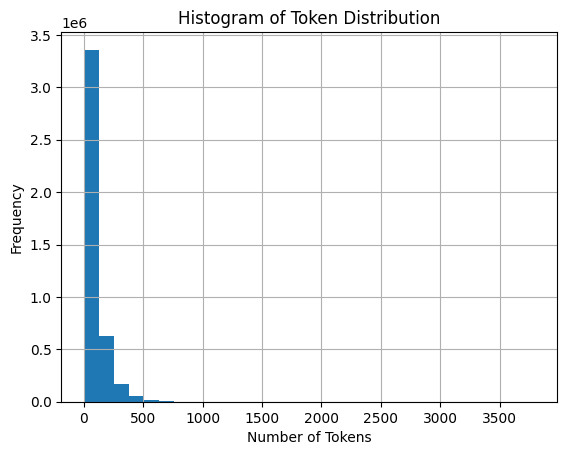

In [4]:
def tokenize_instruction(instruction):
    """Tokenizes an instruction into a list of words."""
    tokens = instruction.split()
    return tokens

token_counts = []
for example in dataset['train']:
    text = example['response']  # Adjust key based on actual dataset structure
    token_counts.append(len(tokenize_instruction(text)))

# Plot token distribution
plt.hist(token_counts, bins=30)  # Adjust bins as needed
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Histogram of Token Distribution")
plt.grid(True)
plt.show()